In [13]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn import preprocessing

### Data pre-processing

Only alter the data pre-processing code if you have completed the challenge for that section.

In [14]:
# The data URI
csv_file_uri = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "target"
]


data_original = pd.read_csv(csv_file_uri, names=column_names, index_col=False)

USE_LABEL_ENCODER = False


if USE_LABEL_ENCODER:

    # Make a copy so that we always have the original data to refer to
    data = data_original.copy(deep=True)

    # Drop the US weights (don't have any value)
    data.drop(["fnlwgt"], axis=1, inplace=True)

    # Create a function that changes the text to a simple binary value
    def convert_target_variable(text):
        if text == " <=50K":
            return 0
        else:
            return 1

    data["target"] = data.target.apply(convert_target_variable)

    encoded_columns = []
    for c in data.columns:
        if data[c].dtype == "object":
            if "{}_encoded".format(c) not in data.columns:
                encoder = preprocessing.LabelEncoder()
                data["{}_encoded".format(c)] = encoder.fit_transform(data[c].values)
                encoded_columns.append(c)
                encoder = None
            else:
                print("{}_encoded already exists".format(c))

    print("Dropping the encoded columns {}".format(encoded_columns))
    data.drop(encoded_columns, axis=1, inplace=True)
    
else:
    
    # Make a copy so that we always have the original data to refer to
    data_pre_dummies = data_original.copy(deep=True)

    # Drop the US weights (don't have any value)
    data_pre_dummies.drop(["fnlwgt"], axis=1, inplace=True)
    
    data = pd.get_dummies(data_pre_dummies)

    # Deletes the original column in this dataframe.
    data.drop(["target_ <=50K"], axis=1, inplace=True)

    # Rename the target
    data.rename(columns={'target_ >50K': 'target' }, inplace=True)

---
### Model

This is the moment we can use the new, numerical, data to plug it into pretty much any classification model. First we'll convert the data to a matrix with our features - that is the data that we want to use to predict from - and an array with our labels - the target variable that indicates if someone makes more than 50k or not.

In [15]:
feature_columns = data.columns.tolist()
feature_columns.remove("target")

In [16]:
X = data[feature_columns].values
y = data["target"].values

Lets use a model from **scikit-learn**: LogisticRegression

For those interested in the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

In [17]:
from sklearn import linear_model

# Create linear regression object
clf = linear_model.LogisticRegression()

# MAGIC
# 
# Train the model using the training sets
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
# Make predictions using the testing set. 
# For now we'll use the last value of the training set.
pred = clf.predict(X[-1,:].reshape(1,-1))

# Print the data 
print(data_original.iloc[data_original.index[-1]])

# and the prediction
print("\nPredict its a {}".format(pred))

probability = clf.predict_proba(X[-1,:].reshape(1,-1))
print("\nWith a probability of {}".format(probability[0,pred[0]]))

# How good is the model by evaluating it 
# on the training set
print("\nThis model has an overall accuracy of {}".format(clf.score(X, y)))

age                                52
workclass                Self-emp-inc
fnlwgt                         287927
education                     HS-grad
education-num                       9
marital-status     Married-civ-spouse
occupation            Exec-managerial
relationship                     Wife
race                            White
sex                            Female
capital-gain                    15024
capital-loss                        0
hours-per-week                     40
native-country          United-States
target                           >50K
Name: 32560, dtype: object

Predict its a [1]

With a probability of 0.9941014990919212

This model has an overall accuracy of 0.8511716470624366


In [19]:
mean_coef = clf.coef_[0].mean()
std_coef = clf.coef_[0].std()
max_coef = clf.coef_[0].max()
min_coef = clf.coef_[0].min()

# Pretty print with the column names
for ix, c in enumerate(feature_columns):
    # I am only going to print the coefficients that are very extreme
    # (i.e., close to the min/max)
    # lets get the variables in a handy way
    this_coef = clf.coef_[0][ix]
    if abs((this_coef-mean_coef)/std_coef) > 1.5:
        print("Column {} is {}".format(c, clf.coef_[0][ix]))

Column education_ Doctorate is 0.6720659358092302
Column education_ Prof-school is 0.7134180340520077
Column marital-status_ Married-civ-spouse is 0.5632405056657125
Column marital-status_ Never-married is -1.258324803845879
Column occupation_ Exec-managerial is 0.6061952854815156
Column occupation_ Farming-fishing is -1.0359311723824225
Column occupation_ Other-service is -1.0353210332832503
Column occupation_ Tech-support is 0.5255145672449617
Column relationship_ Own-child is -1.483173507293428
Column relationship_ Wife is 1.059856402927491
Column sex_ Female is -1.8116274467973055
Column sex_ Male is -0.9238872189901065


**The above is incredibly bad practice (up to the point where I should be fired for even showing you). Why?**

### Exercise: Implement/Annotate Cross Validation

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Create a training and a testing group.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train the model on the training set
clf = None
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

# Predict on the train, test set and compare the results
accuracy_train = clf.score(X_train, y_train)
accuracy_test = clf.score(X_test, y_test)
print("- This model training accuracy of {}".format(accuracy_train))
print("- This model testing accuracy of {}".format(accuracy_test))
print("- The ratio is {}".format(accuracy_test/accuracy_train))

- This model training accuracy of 0.8542032292032292
- This model testing accuracy of 0.846043607329307
- The ratio is 0.9904476808387469


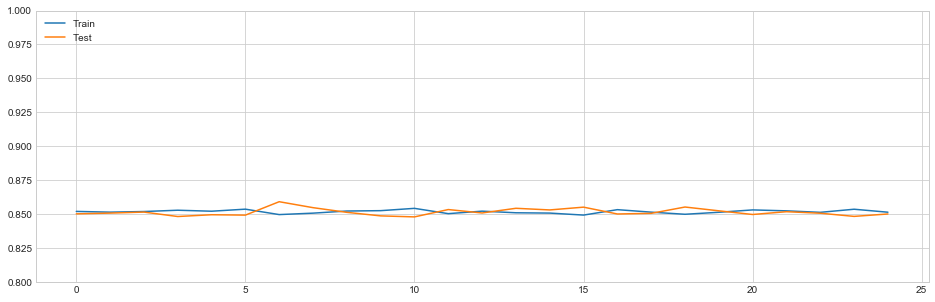

In [22]:
accuracies_train = []
accuracies_test = []

# Cross validation in a loop.
for i in range(25):
    
    # Create a training and a testing group.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # Train the model on the training set
    clf = None
    clf = linear_model.LogisticRegression()
    clf.fit(X_train, y_train)

    # Predict on the train, test set and compare the results
    accuracies_train.append(clf.score(X_train, y_train))
    accuracies_test.append(clf.score(X_test, y_test))

assert len(accuracies_train) == len(accuracies_test)
plt.figure(figsize=(16,5))
plt.plot(range(len(accuracies_train)), accuracies_train, label='Train')
plt.plot(range(len(accuracies_test)), accuracies_test, label='Test')
plt.ylim(0.8,1.0)
plt.legend(loc='upper left')

### Challenge: Parameter tuning

Logistic Regression: [docs](http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html#sphx-glr-auto-examples-linear-model-plot-logistic-l1-l2-sparsity-py)

In [23]:
# There are three hyper-parameters in Logistic Regression you can change:
# C, penalty and tol (tolerance)

# See the docs above to change them.

# The challenge is to test a number of different hyper parameters and find a set
# that performs better than the default values

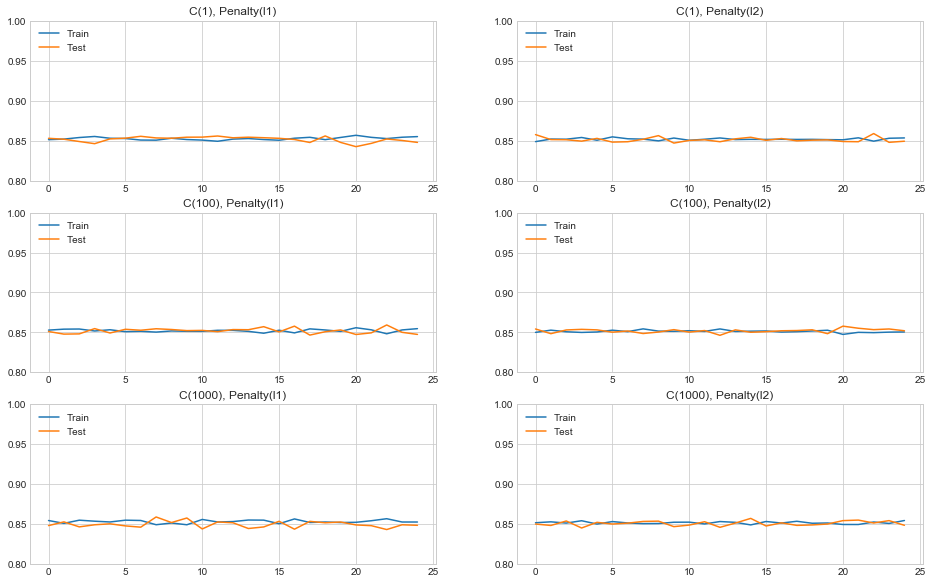

In [24]:
plt.figure(figsize=(16,10))

C_set = [1,100,1000]
penalty_set = ['l1', 'l2']

ctr = 1
for ix,C_param in enumerate(C_set):
    for jx,penalty_param in enumerate(penalty_set):
        
        accuracies_train = []
        accuracies_test = []
        
        # Cross validation in a loop.
        for i in range(25):

            # Create a training and a testing group.
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

            # Train the model on the training set
            clf = None
            clf = linear_model.LogisticRegression(C=C_param, penalty=penalty_param)
            clf.fit(X_train, y_train)

            # Predict on the train, test set and compare the results
            accuracies_train.append(clf.score(X_train, y_train))
            accuracies_test.append(clf.score(X_test, y_test))
            
        plt.subplot(len(C_set),len(penalty_set),ctr)
        ctr += 1
        assert len(accuracies_train) == len(accuracies_test)
        plt.plot(range(len(accuracies_train)), accuracies_train, label='Train')
        plt.plot(range(len(accuracies_test)), accuracies_test, label='Test')
        plt.ylim(0.8,1.0)
        plt.legend(loc='upper left')
        plt.title("C({}), Penalty({})".format(C_param, penalty_param))